# Structure and Surprise in Lana Del Rey’s Lyrics and Poetry

This notebook analyzes song lyrics and poetry using lexical, structural,
and phonetic features. We compare albums across a structure–surprise
space and examine how sound-based structure operates differently in poetry.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

print(os.getcwd())

df = pd.read_csv("../data/features/song_features.csv")
df.head()



C:\Users\mahli\Downloads\lana_analysis-main\lana_analysis-main\CMOR-438\notebooks


,album,first_person_rate,third_person_rate,second_person_rate,phonetic_entropy,song,phonetic_repetition_rate,line_end_similarity,repetition_rate,lexical_entropy
0,aka_lizzy_grant,183.673,0.000,20.408,2.478223,brite_lites.txt,0.818182,0.8409,0.7045,4.4643
1,aka_lizzy_grant,93.333,0.000,120.000,3.203702,for_K_part_2.txt,0.450000,0.4500,0.2000,5.8875
2,aka_lizzy_grant,106.132,0.000,28.302,2.830517,gramma.txt,0.684211,0.6333,0.5167,5.6428
3,aka_lizzy_grant,24.752,9.901,133.663,3.253605,jump.txt,0.628571,0.5143,0.4571,5.0361
4,aka_lizzy_grant,134.259,4.630,32.407,2.865708,kill_kill.txt,0.685714,0.6286,0.5714,5.0833


In [2]:
df.columns

Index(['album', 'first_person_rate', 'third_person_rate', 'second_person_rate',
       'phonetic_entropy', 'song', 'phonetic_repetition_rate',
       'line_end_similarity', 'repetition_rate', 'lexical_entropy'],
      dtype='object')

In [3]:
import pandas as pd

# 1) Load the features table (adjust path if needed)
df = pd.read_csv("../data/features/song_features.csv")

# 2) Define which "albums" are actually poetry collections
POETRY_ALBUMS = {
    "ariel",
    "violet_bent_backwards_over_the_grass",
    "my_poetry",
}

# 3) Ensure a text_type column exists (no KeyError ever again)
df["text_type"] = df["album"].apply(lambda a: "poem" if a in POETRY_ALBUMS else "song")

# 4) Clean splits you can reuse everywhere
df_songs = df[df["text_type"] == "song"].copy()
df_poems = df[df["text_type"] == "poem"].copy()

# 5) Quick sanity checks (so you can trust it)
print(df["text_type"].value_counts())
print("Song albums:", sorted(df_songs["album"].unique()))
print("Poetry collections:", sorted(df_poems["album"].unique()))


text_type
song    126
poem     42
Name: count, dtype: int64
Song albums: ['aka_lizzy_grant', 'blue_banisters', 'born_to_die', 'chemtrails_over_the_country_club', 'did_you_know_ocean_blvd', 'honeymoon', 'lust_for_life', 'nfr', 'ultraviolence']
Poetry collections: ['ariel', 'my_poetry', 'violet_bent_backwards_over_the_grass']


## Song Albums: Structure vs. Surprise

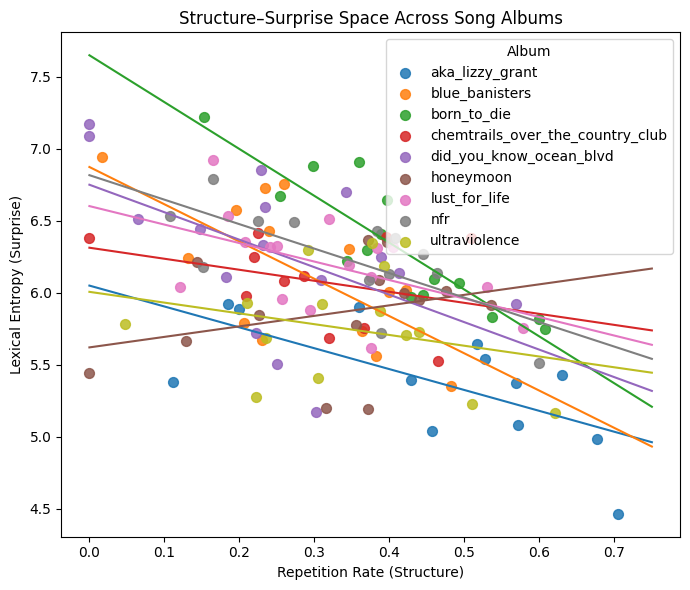

In [4]:
plt.figure(figsize=(7, 6))

albums = df_songs["album"].unique()

for album in albums:
    sub = df_songs[df_songs["album"] == album]
    plt.scatter(
        sub["repetition_rate"],
        sub["lexical_entropy"],
        s=50,
        alpha=0.85,
        label=album
    )

    if len(sub) > 1:
        x = sub["repetition_rate"].values
        y = sub["lexical_entropy"].values
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(0, 0.75, 100)
        plt.plot(xs, m * xs + b)

plt.xlabel("Repetition Rate (Structure)")
plt.ylabel("Lexical Entropy (Surprise)")
plt.title("Structure–Surprise Space Across Song Albums")
plt.legend(title="Album")
plt.tight_layout()
plt.show()


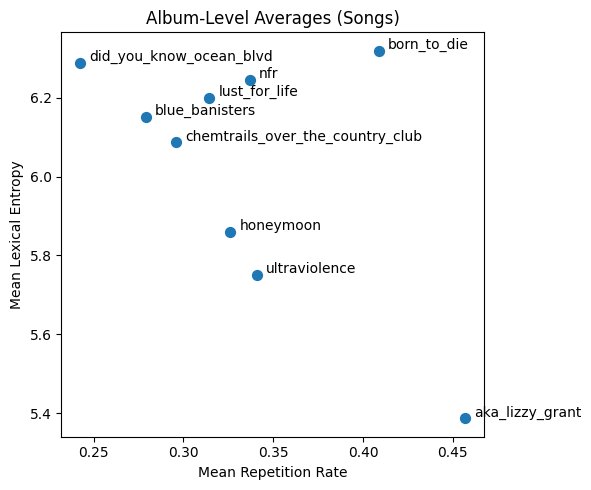

In [5]:
song_means = (
    df_songs
    .groupby("album")[["repetition_rate", "lexical_entropy"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 5))
plt.scatter(
    song_means["repetition_rate"],
    song_means["lexical_entropy"],
    s=50
)

for _, row in song_means.iterrows():
    plt.text(
        row["repetition_rate"] + 0.005,
        row["lexical_entropy"] + 0.005,
        row["album"]
    )

plt.xlabel("Mean Repetition Rate")
plt.ylabel("Mean Lexical Entropy")
plt.title("Album-Level Averages (Songs)")
plt.tight_layout()
plt.show()


In [6]:
pip install pronouncing

Note: you may need to restart the kernel to use updated packages.


## Poetry: Phonetic Structure vs Surprise


In [7]:
import pronouncing
import re

def get_phonetic_ending(word):
    phones = pronouncing.phones_for_word(word.lower())
    if not phones:
        return None

    # Take first pronunciation
    phonemes = phones[0].split()

    # Get last stressed vowel onward
    for i in range(len(phonemes) - 1, -1, -1):
        if phonemes[i][-1].isdigit():  # stress marker
            return tuple(phonemes[i:])
    return tuple(phonemes[-2:])


C:\Users\mahli\AppData\Local\Programs\Python\Python313\Lib\site-packages\pronouncing\__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


In [8]:
def phonetic_endings(text):
    endings = []
    for line in text.split("\n"):
        words = re.findall(r"\b\w+\b", line)
        if words:
            pe = get_phonetic_ending(words[-1])
            if pe:
                endings.append(pe)
    return endings


In [9]:
from collections import Counter

def phonetic_repetition_rate(endings):
    if not endings:
        return 0
    counts = Counter(endings)
    repeats = sum(c - 1 for c in counts.values() if c > 1)
    return repeats / len(endings)


In [10]:
import math

def phonetic_entropy(endings):
    if not endings:
        return 0
    counts = Counter(endings)
    total = sum(counts.values())
    probs = [c / total for c in counts.values()]
    return -sum(p * math.log2(p) for p in probs)


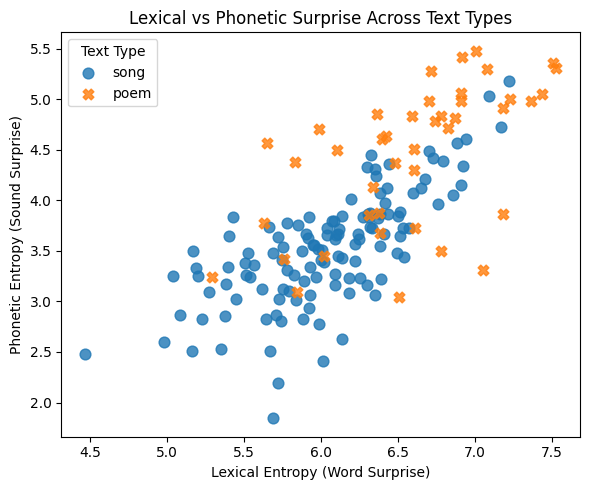

In [12]:
plt.figure(figsize=(6, 5))

for ttype, marker in [("song", "o"), ("poem", "X")]:
    sub = df[df["text_type"] == ttype]
    plt.scatter(
        sub["lexical_entropy"],
        sub["phonetic_entropy"],
        s=60,
        alpha=0.8,
        marker=marker,
        label=ttype
    )

plt.xlabel("Lexical Entropy (Word Surprise)")
plt.ylabel("Phonetic Entropy (Sound Surprise)")
plt.title("Lexical vs Phonetic Surprise Across Text Types")
plt.legend(title="Text Type")
plt.tight_layout()
plt.show()


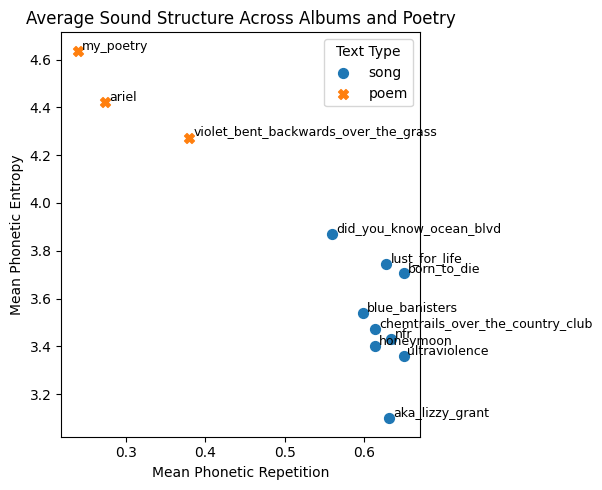

In [13]:
centroids = (
    df.groupby(["text_type", "album"])[
        ["phonetic_repetition_rate", "phonetic_entropy"]
    ]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 5))

for ttype, marker in [("song", "o"), ("poem", "X")]:
    sub = centroids[centroids["text_type"] == ttype]
    plt.scatter(
        sub["phonetic_repetition_rate"],
        sub["phonetic_entropy"],
        s=50,
        marker=marker,
        label=ttype
    )
    for _, row in sub.iterrows():
        plt.text(
            row["phonetic_repetition_rate"] + 0.005,
            row["phonetic_entropy"] + 0.005,
            row["album"],
            fontsize=9
        )

plt.xlabel("Mean Phonetic Repetition")
plt.ylabel("Mean Phonetic Entropy")
plt.title("Average Sound Structure Across Albums and Poetry")
plt.legend(title="Text Type")
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd
df = pd.read_csv("../data/features/song_features.csv")
print(df.columns)


Index(['album', 'first_person_rate', 'third_person_rate', 'second_person_rate',
       'phonetic_entropy', 'song', 'phonetic_repetition_rate',
       'line_end_similarity', 'repetition_rate', 'lexical_entropy'],
      dtype='object')


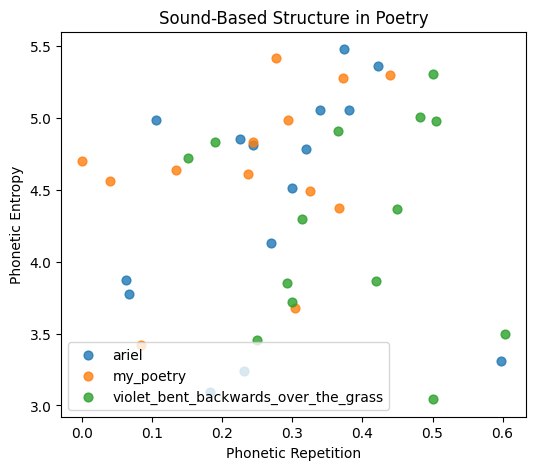

In [18]:
plt.figure(figsize=(6,5))

for collection in df_poems["album"].unique():
    sub = df_poems[df_poems["album"] == collection]
    plt.scatter(
        sub["phonetic_repetition_rate"],
        sub["phonetic_entropy"],
        s=40,
        alpha=0.8,
        label=collection
    )

plt.xlabel("Phonetic Repetition")
plt.ylabel("Phonetic Entropy")
plt.title("Sound-Based Structure in Poetry")
plt.legend()
plt.show()


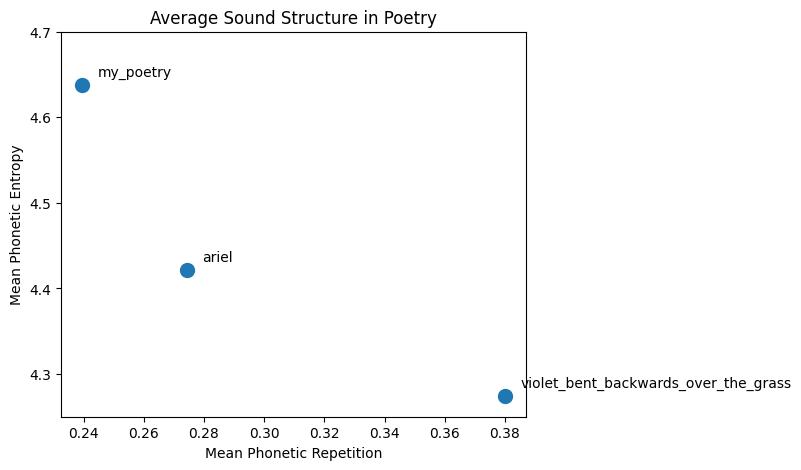

In [24]:
poem_means = (
    df_poems
    .groupby("album")[["phonetic_repetition_rate", "phonetic_entropy"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,5))

plt.scatter(
    poem_means["phonetic_repetition_rate"],
    poem_means["phonetic_entropy"],
    s=100
)

for _, row in poem_means.iterrows():
    plt.text(
        row["phonetic_repetition_rate"] + 0.005,
        row["phonetic_entropy"] + 0.01,
        row["album"],
        fontsize=10
    )

plt.xlabel("Mean Phonetic Repetition")
plt.ylabel("Mean Phonetic Entropy")
plt.ylim(4.25, 4.7)
plt.title("Average Sound Structure in Poetry")
plt.show()


In [28]:
!pip install seaborn


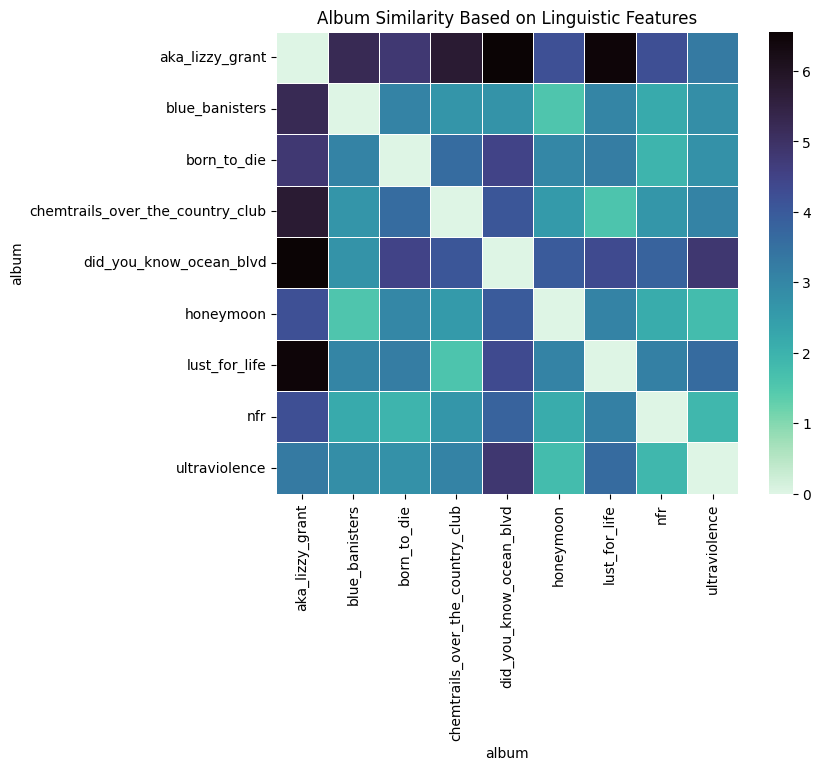

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("../data/features/song_features.csv")

# Exclude poetry if desired
songs = df[~df["album"].isin([
    "ariel",
    "violet_bent_backwards_over_the_grass",
    "my_poetry"
])]

features = [
    "repetition_rate",
    "lexical_entropy",
    "phonetic_repetition_rate",
    "phonetic_entropy",
    "first_person_rate",
    "second_person_rate"
]

album_means = songs.groupby("album")[features].mean()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(album_means)


dist_matrix = euclidean_distances(X_scaled)
dist_df = pd.DataFrame(
    dist_matrix,
    index=album_means.index,
    columns=album_means.index
)


plt.figure(figsize=(8, 6))
sns.heatmap(
    dist_df,
    cmap="mako_r",
    square=True,
    linewidths=0.5
)
plt.title("Album Similarity Based on Linguistic Features")
plt.show()
